In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from adahessian import Adahessian, get_params_grad
import torch.optim.lr_scheduler as lr_scheduler
from UCI_loader import UCIDatasets
import matplotlib.pyplot as plt

In [2]:
dataClass= UCIDatasets("energy", data_path="", n_splits=10) # has a field named 'data' that contains the data

trainData= dataClass.get_split(train=True)
trainLoader= torch.utils.data.DataLoader(trainData, batch_size= dataClass.data.shape[0], shuffle= True) # creating a loader with full batch size to ensure LBFGS works
testData= dataClass.get_split(train= False)
testLoader= torch.utils.data.DataLoader(testData, batch_size= dataClass.data.shape[0], shuffle= True)

In [3]:
inDim, outDim= 8, 2 

In [4]:
# defining all the criterions to be used in the following experiments:
def tiltedLC(x, y, tau, h):
    e= y-x # errors
    ind= (torch.sign(e)+1)/2 # the division in the log-cosh is only about the origin
    quantFactor= (1-tau)*(1-ind) + tau*ind
    loss= quantFactor*torch.log(torch.cosh(e))
    loss= torch.mean(loss)
    return loss

class TiltedLC(nn.Module):
    def __init__(self):
        super(TiltedLC, self).__init__()
    def forward(self, x, y, tau, h):
        return tiltedLC(x, y, tau, h)

In [5]:
# global initialisations:
h= 0.4 # smoothing parameter for the log-cosh 
tau= 0.5
device= ('cuda' if torch.cuda.is_available() else 'cpu')
criterion1= TiltedLC()
criterion2= nn.MSELoss()
criterion3= nn.L1Loss()
N_EPOCHS= 100

In [7]:
class LALRnetwork(nn.Module):
    def __init__(self, size1, size2, inDim, outDim, drop):
        super(LALRnetwork, self).__init__()
        self.l1= nn.Linear(inDim, size1)
        self.l2= nn.Dropout(p= drop)
        self.l3= nn.Linear(size1, size2)
        self.l4= nn.Dropout(p= drop)
        self.l5= nn.Linear(size2, outDim)

    def forward(self, x):
        x= F.tanh(self.l1(x))
        x= F.tanh(self.l3(self.l2(x)))
        x= self.l5(self.l4(x))
        return x
    
    def penU(self, x):
        x= F.tanh(self.l2(self.l1(x)))
        x= F.tanh(self.l4(self.l3(x)))
        return x

In [8]:
size1, size2= 300, 300
model_LBFGS_LC= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LBFGS_LC= optim.LBFGS(model_LBFGS_LC.parameters())
lossList_LBFGS_LC= []
valList_LBFGS_LC= []

model_LBFGS_MSE= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LBFGS_MSE= optim.LBFGS(model_LBFGS_MSE.parameters())
lossList_LBFGS_MSE= []
valList_LBFGS_MSE= []

model_CLR_L1= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_L1= optim.SGD(model_CLR_L1.parameters(), lr= 0.1)
lossList_CLR_L1= []
valList_CLR_L1= []

model_CLR_LC= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_LC= optim.SGD(model_CLR_LC.parameters(), lr= 0.1)
lossList_CLR_LC= []
valList_CLR_LC= []

model_CLR_MSE= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_MSE= optim.SGD(model_CLR_MSE.parameters(), lr= 0.1)
lossList_CLR_MSE= []
valList_CLR_MSE= []

In [15]:
def trainLBFGS(model, optimizer, criterion, tau, epochs, ls_list, valList, loss_name):
    """
    Training loop used for LBFGS and conjugate gradient training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            def closure():
                optimizer.zero_grad()
                outputs= model(inputs)
                if loss_name== "MSE":
                    loss= criterion(outputs, labels)
                else:
                    loss= criterion(outputs, labels, tau, h)
                loss.backward()
                return loss
            # optimizer.step(closure)
            # optimizer.zero_grad() 
            # outputs= model(inputs) 
            # loss= criterion(outputs, labels, tau, h) 
            # loss.backward()
            optimizer.step(closure) 
        # ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        model.eval()
        for inputs, labels in testLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            loss= torch.sqrt(criterion2(outputs, labels))
            val_loss+= loss.item()
        valList.append(val_loss/len(testLoader))
        print("Epoch: {} Training loss: {} Validation loss: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(testLoader)))
        
def trainConstantLR(model, optimizer, criterion, tau, epochs, ls_list, valList, loss_name):
    """
    Training loop used for constantLR
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            if loss_name== "LC":
                loss= criterion(outputs, labels, tau, h)
            else:
                loss= criterion(outputs, labels)
            loss.backward()
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        model.eval()
        for inputs, labels in testLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            loss= torch.sqrt(criterion2(outputs, labels))
            val_loss+= loss.item()
        valList.append(val_loss/len(testLoader))
        print("Epoch: {} Training loss: {} Validation loss: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(testLoader)))

In [10]:
# LBFGS, LC
trainLBFGS(model_LBFGS_LC, optimizer_LBFGS_LC, criterion1, tau,  N_EPOCHS, lossList_LBFGS_LC, valList_LBFGS_LC, "LC")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0 Training loss: 0.0 Validation loss: 0.3282132148742676
Epoch: 1 Training loss: 0.0 Validation loss: 0.31446823477745056
Epoch: 2 Training loss: 0.0 Validation loss: 0.29763635993003845
Epoch: 3 Training loss: 0.0 Validation loss: 0.2670964300632477
Epoch: 4 Training loss: 0.0 Validation loss: 0.22761330008506775
Epoch: 5 Training loss: 0.0 Validation loss: 0.20399606227874756
Epoch: 6 Training loss: 0.0 Validation loss: 0.18691617250442505
Epoch: 7 Training loss: 0.0 Validation loss: 0.17712640762329102
Epoch: 8 Training loss: 0.0 Validation loss: 0.19225065410137177
Epoch: 9 Training loss: 0.0 Validation loss: 0.16895215213298798
Epoch: 10 Training loss: 0.0 Validation loss: 0.1661866158246994
Epoch: 11 Training loss: 0.0 Validation loss: 0.16492925584316254
Epoch: 12 Training loss: 0.0 Validation loss: 0.15785811841487885
Epoch: 13 Training loss: 0.0 Validation loss: 0.15650437772274017
Epoch: 14 Training loss: 0.0 Validation loss: 0.15457773208618164
Epoch: 15 Training loss

In [11]:
# LBFGS, MSE
trainLBFGS(model_LBFGS_MSE, optimizer_LBFGS_MSE, criterion2, tau,  N_EPOCHS, lossList_LBFGS_MSE, valList_LBFGS_MSE, "MSE")

Epoch: 0 Training loss: 0.0 Validation loss: 0.3298576772212982
Epoch: 1 Training loss: 0.0 Validation loss: 0.3177228569984436
Epoch: 2 Training loss: 0.0 Validation loss: 0.30034708976745605
Epoch: 3 Training loss: 0.0 Validation loss: 0.2673923969268799
Epoch: 4 Training loss: 0.0 Validation loss: 0.2226599007844925
Epoch: 5 Training loss: 0.0 Validation loss: 0.19695940613746643
Epoch: 6 Training loss: 0.0 Validation loss: 0.17282728850841522
Epoch: 7 Training loss: 0.0 Validation loss: 0.1654045432806015
Epoch: 8 Training loss: 0.0 Validation loss: 0.16192102432250977
Epoch: 9 Training loss: 0.0 Validation loss: 0.1597985476255417
Epoch: 10 Training loss: 0.0 Validation loss: 0.15620875358581543
Epoch: 11 Training loss: 0.0 Validation loss: 0.15327146649360657
Epoch: 12 Training loss: 0.0 Validation loss: 0.1523575633764267
Epoch: 13 Training loss: 0.0 Validation loss: 0.1536063253879547
Epoch: 14 Training loss: 0.0 Validation loss: 0.1494077742099762
Epoch: 15 Training loss: 0.0 

In [12]:
# CLR, L1:
trainConstantLR(model_CLR_L1, optimizer_CLR_L1, criterion3, tau,  N_EPOCHS, lossList_CLR_L1, valList_CLR_L1, "L1")

Epoch: 0 Training loss: 0.9093198180198669 Validation loss: 0.5454108119010925
Epoch: 1 Training loss: 0.4440552890300751 Validation loss: 0.43683093786239624
Epoch: 2 Training loss: 0.3357156813144684 Validation loss: 0.40775665640830994
Epoch: 3 Training loss: 0.3305158317089081 Validation loss: 0.4206060767173767
Epoch: 4 Training loss: 0.33660072088241577 Validation loss: 0.4167877435684204
Epoch: 5 Training loss: 0.3506762385368347 Validation loss: 0.431005597114563
Epoch: 6 Training loss: 0.34609922766685486 Validation loss: 0.4131128191947937
Epoch: 7 Training loss: 0.3478061854839325 Validation loss: 0.40818554162979126
Epoch: 8 Training loss: 0.3271120488643646 Validation loss: 0.3968852460384369
Epoch: 9 Training loss: 0.3321595788002014 Validation loss: 0.4038558602333069
Epoch: 10 Training loss: 0.3260256052017212 Validation loss: 0.38983747363090515
Epoch: 11 Training loss: 0.3211667537689209 Validation loss: 0.3879890441894531
Epoch: 12 Training loss: 0.3061442971229553 V

In [13]:
# CLR, MSE
trainConstantLR(model_CLR_MSE, optimizer_CLR_MSE, criterion2, tau,  N_EPOCHS, lossList_CLR_MSE, valList_CLR_MSE, "MSE")

Epoch: 0 Training loss: 1.0420897006988525 Validation loss: 0.6447374224662781
Epoch: 1 Training loss: 0.4142497479915619 Validation loss: 0.5014262795448303
Epoch: 2 Training loss: 0.2974858283996582 Validation loss: 0.3997075855731964
Epoch: 3 Training loss: 0.1614500731229782 Validation loss: 0.3470926880836487
Epoch: 4 Training loss: 0.1439753919839859 Validation loss: 0.3529699742794037
Epoch: 5 Training loss: 0.12938371300697327 Validation loss: 0.3355365991592407
Epoch: 6 Training loss: 0.12923920154571533 Validation loss: 0.34225794672966003
Epoch: 7 Training loss: 0.12948743999004364 Validation loss: 0.3331418037414551
Epoch: 8 Training loss: 0.12699486315250397 Validation loss: 0.3381032347679138
Epoch: 9 Training loss: 0.12308933585882187 Validation loss: 0.33202800154685974
Epoch: 10 Training loss: 0.11968373507261276 Validation loss: 0.3339344263076782
Epoch: 11 Training loss: 0.12034507095813751 Validation loss: 0.33242306113243103
Epoch: 12 Training loss: 0.1193582639098

In [16]:
# CLR, LC
trainConstantLR(model_CLR_LC, optimizer_CLR_LC, criterion1, tau,  N_EPOCHS, lossList_CLR_LC, valList_CLR_LC, "LC")

Epoch: 0 Training loss: 0.19018615782260895 Validation loss: 0.7493488788604736
Epoch: 1 Training loss: 0.12839804589748383 Validation loss: 0.6156922578811646
Epoch: 2 Training loss: 0.09027354419231415 Validation loss: 0.5286970138549805
Epoch: 3 Training loss: 0.0692489817738533 Validation loss: 0.4743185341358185
Epoch: 4 Training loss: 0.056910667568445206 Validation loss: 0.4396529495716095
Epoch: 5 Training loss: 0.04894758760929108 Validation loss: 0.4157683849334717
Epoch: 6 Training loss: 0.04393447935581207 Validation loss: 0.3987039029598236
Epoch: 7 Training loss: 0.04140431061387062 Validation loss: 0.3854612410068512
Epoch: 8 Training loss: 0.03732926398515701 Validation loss: 0.37547749280929565
Epoch: 9 Training loss: 0.03561697527766228 Validation loss: 0.3676394820213318
Epoch: 10 Training loss: 0.03312951326370239 Validation loss: 0.36142393946647644
Epoch: 11 Training loss: 0.03224359080195427 Validation loss: 0.3566060960292816
Epoch: 12 Training loss: 0.031577356

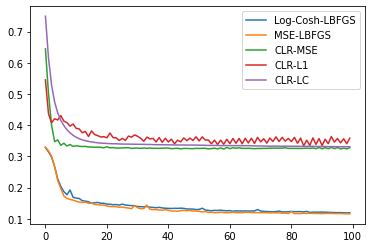

In [22]:
plt.plot(range(100), valList_LBFGS_LC, label="Log-Cosh-LBFGS")
plt.plot(range(100), valList_LBFGS_MSE, label="MSE-LBFGS")
plt.plot(range(100), valList_CLR_MSE, label="CLR-MSE")
plt.plot(range(100), valList_CLR_L1, label="CLR-L1")
plt.plot(range(100), valList_CLR_LC, label="CLR-LC")
plt.legend()